## Part 5: Predict Next Purchase Day

Notes from this notebook comes from various resources listed at the end of the notebook. This will be good exposure to using more plotly to produce interactable plots vs. matplotlib as well predictive modeling.

### Business Question

__What if we knew that our customer is going to purchase within 7 days? What if we knew that they were not going to purchase until another promotion?__

We want to try to understand our customers to the best of our abilities and knowing when they purchase or have an estimated timeframe will be helpful. If we know a customer is going to purchase within the next 7 days, we can segment them into another group so we will not spend marketing resources since they will make a purchase anyways.

If we knew they were going to purchase, let's solidy that assumption and send them email campaigns (nudges) on their behavior like last purchase type, any current sales, last viewed item, and more. By figuring out the window, inbound marketing can be effective as well if there is no purchase in the predicted time window. 

One step in the process could be to figure out what stage the customer may be at, if they were close like at the cart abandonment stage then we want to see why. Was it too expensive? How long was it on the cart before it was removed? Did they view certain pages/items? Did they purchase something else? Some of these answers will help solidify a better and clearer answer to our questions.

-------

### Areas of Focus

Business
- Creating a strategy for both marketing and customer service that will lead the customer back to a purchase
    - Marketing
        - Inbound marketing
        - Email campaigns: reminding of item in cart, last purchase, complimentary purchases, etc.
        - Promotions
    - Customer Service
        - Update with educational content / blog posts
        - Ask if there is anything they can do to make their journey easier
   
Analytics / Prediction
- Feature Engineering
- Machine Learning
    - Hyperparameter Tuning

### Results

### Issues

### Process

### Design

### Libraries

Using TensorFlow backend.


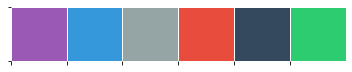

In [1]:
# Toolbox 101
from datetime import datetime, timedelta,date
import pandas as pd
import pandas_profiling
import numpy as np
import random as rand
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# import plotly.plotly as py
import plotly.graph_objs as go # graph_objects in version 4 (currently have plotly v3 installed)
import plotly.offline as pyoff

# Stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy import stats

# Deep learning
import keras

# Models
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBRegressor, XGBClassifier, plot_importance, plot_tree

# Evaluation
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report, make_scorer
from sklearn.metrics import accuracy_score, recall_score, precision_recall_curve
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score

# Ignore useless warnings
import warnings
warnings.filterwarnings(action='ignore')

# Preset data display
pd.options.display.max_seq_items = 5000
pd.options.display.max_rows = 5000

# Set palette
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette(flatui)
sns.palplot(sns.color_palette(flatui))
#34495e

seed = 100

### Helpers

In [2]:
def pct_bar_labels():
    '''
    Function used to label the relative frequency on top of each bars
    '''
    # Set font size
    fs=15
    
    # Set plot label and ticks
    plt.ylabel('Relative Frequency (%)', fontsize=fs)
    plt.xticks(rotation=0, fontsize=fs)
    plt.yticks([])
    
    # Set individual bar labels in proportional scale
    for x in ax1.patches:
        ax1.annotate(str(x.get_height()) + '%', 
        (x.get_x() + x.get_width()/2., x.get_height()), ha='center', va='center', xytext=(0, 7), 
        textcoords='offset points', fontsize=fs, color='black')

def freq_table(var):
    '''
    Define plot global variables
    Create a function that will populate a frequency table (%)
    Get counts per feature then get the percentage over the total counts
    '''
    global ax, ax1
    
    # Get Values and pct and combine it into a dataframe
    count_freq = var.value_counts()
    pct_freq = round(var.value_counts(normalize=True)*100, 2)
    
    # Create a dataframe
    df = pd.DataFrame({'Count': count_freq, 'Percentage': pct_freq})
    
    # Print variable name
    print('Frequency of', var.name, ':')
    display(df)
    
    # Create plot
    ax1 = pct_freq.plot.bar(title='Percentage of {}'.format(var.name), figsize=(12,8))
    ax1.title.set_size(15)
    pct_bar_labels()
    plt.show()
    
# Define a null function
def get_nulls(df):
    
    # Get null pct and counts
    null_cols = pd.DataFrame(df.isnull().sum().sort_values(ascending=False), columns=['Null Data Count'])
    null_cols_pct = pd.DataFrame(round(df.isnull().sum().sort_values(ascending=False)/len(df),5), columns=['Null Data Pct'])

    # Combine dataframes horizontally
    null_cols_df = pd.DataFrame(pd.concat([null_cols, null_cols_pct], axis=1))

    all_nulls = null_cols_df[null_cols_df['Null Data Pct']>0]

    # Print
    print('There are', len(all_nulls), 'columns with missing values.')
    return all_nulls

# Define plot_nulls function
def plot_nulls(train):
    # Get null pct and counts
    null_cols = pd.DataFrame(train.isnull().sum().sort_values(ascending=False), columns=['Null Data Count'])
    null_cols_pct = pd.DataFrame(round(train.isnull().sum().sort_values(ascending=False)/len(train),5)*100, columns=['Null Data %'])

    # Combine horizontally (axis=1) into a dataframe with column names (keys=[]) then to a data frame
    null_cols_df = pd.DataFrame(pd.concat([null_cols, null_cols_pct], axis=1))

    all_nulls = null_cols_df[null_cols_df['Null Data %']>0]

    # Create figure space
    if len(all_nulls) > 8:
        plt.figure(figsize=(12, 8))
    elif len(all_nulls) > 5:
        plt.figure(figsize=(6, 8))
    else:
        plt.figure(figsize=(4, 8))

    # Create plot
    sns.barplot(x=all_nulls.index,
                y='Null Data %',
                data=all_nulls)

    # Set plot features
    plt.ylim(0, 100)
    plt.xticks(rotation='90')
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of Missing Values', fontsize=15)
    plt.title('Percent of Missing Data by Features', fontsize=15)
    plt.show()
    
# Create a new function to capture feature importance for models
def feature_importance(model):
    
    importance = pd.DataFrame({'Feature': headers,
                               'Importance': np.round(model.feature_importances_,3)})
    
    importance = importance.sort_values(by = 'Importance', ascending = False).set_index('Feature')
    
    return importance

### Data

In [3]:
# Import data
data = pd.read_csv('LargeData/18-online-retail.csv', encoding='unicode_escape')

### Cleaning steps
- Select only UK customers
- Change date to datetime
- Check data summaries
- Remove null customer ID if we group the data by user
- Feature engineering

### Show all countries

In [4]:
data.groupby('Country')['Country'].value_counts().sort_values(ascending=False)

Country               Country             
United Kingdom        United Kingdom          495478
Germany               Germany                   9495
France                France                    8557
EIRE                  EIRE                      8196
Spain                 Spain                     2533
Netherlands           Netherlands               2371
Belgium               Belgium                   2069
Switzerland           Switzerland               2002
Portugal              Portugal                  1519
Australia             Australia                 1259
Norway                Norway                    1086
Italy                 Italy                      803
Channel Islands       Channel Islands            758
Finland               Finland                    695
Cyprus                Cyprus                     622
Sweden                Sweden                     462
Unspecified           Unspecified                446
Austria               Austria                    401
Den

### Count distinct countries

In [5]:
print('There are', data.groupby('Country')['Country'].nunique().sum(), 'unique countries in the dataset.')

There are 38 unique countries in the dataset.


### Select only UK customers

In [6]:
data = data.query("Country=='United Kingdom'").reset_index(drop=True)

### Update the date feature to datetime

In [7]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

### Basic summaries

Get an idea of the data dimensions and features in the set.

In [8]:
data.shape

(495478, 8)

In [9]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,572891,23343,20713,-400,2011-10-26 14:14:00,0.00,NaN,United Kingdom
1,536522,72800B,4 PURPLE FLOCK DINNER CANDLES,2,2010-12-01 12:49:00,2.55,15012.0,United Kingdom
2,537044,72800B,4 PURPLE FLOCK DINNER CANDLES,12,2010-12-05 10:52:00,2.55,18055.0,United Kingdom
3,539595,72800B,4 PURPLE FLOCK DINNER CANDLES,2,2010-12-20 13:43:00,5.06,NaN,United Kingdom
4,540247,72800B,4 PURPLE FLOCK DINNER CANDLES,1,2011-01-05 15:56:00,2.55,15464.0,United Kingdom


In [10]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,495478.000000,495478.000000,361878.000000
mean,8.605486,4.532422,15547.871368
std,227.588756,99.315438,1594.402590
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,14194.000000
50%,3.000000,2.100000,15514.000000
75%,10.000000,4.130000,16931.000000
max,80995.000000,38970.000000,18287.000000


### Check for nulls

Always check for nulls as we are still in the preprocessing/exploring stage of the project.

There are 2 columns with missing values.
             Null Data Count  Null Data Pct
CustomerID            133600        0.26964
Description             1454        0.00293


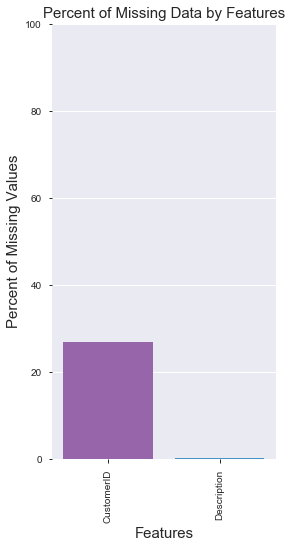

In [11]:
print(get_nulls(data))
plot_nulls(data)

We have two features with some null values.

### Training and testing data design

To build the model, we need to have at least a train and test set. We will want to have more training data in our initial design. The train set will include 6 months of behavioral data to predict a customer's first purchase date in the next three months as well as no purchase.

### Split the data

In [14]:
train = data[(data['InvoiceDate'] < date(2011, 9, 1)) & (data['InvoiceDate'] >= date(2011, 3, 1))].reset_index(drop=True)
test = data[(data['InvoiceDate'] >= date(2011, 9, 1)) & (data['InvoiceDate'] < date(2011, 12, 1))].reset_index(drop=True)

In [15]:
train.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,548642,72800B,4 PURPLE FLOCK DINNER CANDLES,3,2011-04-01 13:00:00,2.55,17287.0,United Kingdom
1,548808,72800B,4 PURPLE FLOCK DINNER CANDLES,3,2011-04-04 12:55:00,2.55,17774.0,United Kingdom
2,550459,72800B,4 PURPLE FLOCK DINNER CANDLES,1,2011-04-18 13:17:00,2.55,18116.0,United Kingdom
3,550459,72800B,4 PURPLE FLOCK DINNER CANDLES,1,2011-04-18 13:17:00,2.55,18116.0,United Kingdom
4,553194,72800B,4 PURPLE FLOCK DINNER CANDLES,1,2011-05-15 13:37:00,2.55,16283.0,United Kingdom


In [16]:
test.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,572891,23343,20713,-400,2011-10-26 14:14:00,0.00,NaN,United Kingdom
1,565427,72800B,4 PURPLE FLOCK DINNER CANDLES,3,2011-09-04 12:49:00,2.55,17774.0,United Kingdom
2,565856,72800B,4 PURPLE FLOCK DINNER CANDLES,2,2011-09-07 14:09:00,2.55,17345.0,United Kingdom
3,567128,72800B,4 PURPLE FLOCK DINNER CANDLES,4,2011-09-16 14:04:00,2.55,18055.0,United Kingdom
4,569220,72800B,4 PURPLE FLOCK DINNER CANDLES,1,2011-10-02 13:26:00,2.55,16007.0,United Kingdom


In [20]:
print('Max Date:', train.InvoiceDate.max())
print('Min Date:', train.InvoiceDate.min())
print('Date Difference:', train.InvoiceDate.max()- train.InvoiceDate.min())

Max Date: 2011-08-31 17:45:00
Min Date: 2011-03-01 08:30:00
Date Difference: 183 days 09:15:00


### Create a grouped user dataframe

In [12]:
# # TODO: Apply PCA by fitting the good data with only two dimensions
# pca = PCA(n_components=2).fit(good_data)

# # TODO: Transform the good data using the PCA fit above
# reduced_data = pca.transform(good_data)

# # TODO: Transform log_samples using the PCA fit above
# pca_samples = pca.transform(log_samples)

# # Create a DataFrame for the reduced data
# reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

# # Display sample log-data after applying PCA transformation in two dimensions
# display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

# # Create a biplot
# vs.biplot(good_data, reduced_data, pca)